In [1]:
import pickle

test_data_directory = "../../../training_data/data/task_from_graph_test.pkl"
with open(test_data_directory, 'rb') as f:
    filtered_iso_test = pickle.load(f)

for graph in filtered_iso_test:
    print(f"Lenght is {len(graph)}")

Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100
Lenght is 100


In [2]:
import torch
from mean.model import GCN

def do_inference(data, model_path, input_features=3):
    model_state_dict = torch.load(model_path,  map_location=torch.device('cpu'))
    model =  GCN(num_node_features=input_features).to(torch.device('cpu'))
    model.load_state_dict(model_state_dict)
    pred_latency = model(data.x, data.edge_index, data.batch)
    actual_latency = data.y
    model.load_state_dict(model_state_dict)
    return pred_latency, actual_latency

data = filtered_iso_test[0][0]
pred, actual = do_inference(data, "mean/LatNet_100_state_dict.pth")

print(f"Predicted latency: {pred}")
print(f"Actual latency: {actual}")

Predicted latency: tensor([[2035.2965]], grad_fn=<AddmmBackward0>)
Actual latency: tensor([2073.])


In [3]:
# Box Plot  
list_of_latency_list = []

mean_latency_list = []
no_outlier_latency_list = []
iqr_latency_list = []
upto_q2 = []

for same_graph in filtered_iso_test:
    latency_list = []
    to_infer = True
    for graph in same_graph:
        latency_list.append(graph.y.item())
        if to_infer:
            mean_pred, _ = do_inference(graph, "mean/LatNet_2000_state_dict.pth")
            mean_latency_list.append(mean_pred.item())

            no_outlier_pred, _ = do_inference(graph, "no_outliers/LatNet_1500_state_dict.pth")
            no_outlier_latency_list.append(no_outlier_pred.item())

            iqr_pred, _ = do_inference(graph, "iqr/LatNet_1500_state_dict.pth")
            iqr_latency_list.append(iqr_pred.item())

            upto_q2_pred, _ = do_inference(graph, "upto_q2/LatNet_250_state_dict.pth")
            upto_q2.append(upto_q2_pred.item())

            to_infer = False
    list_of_latency_list.append(latency_list)

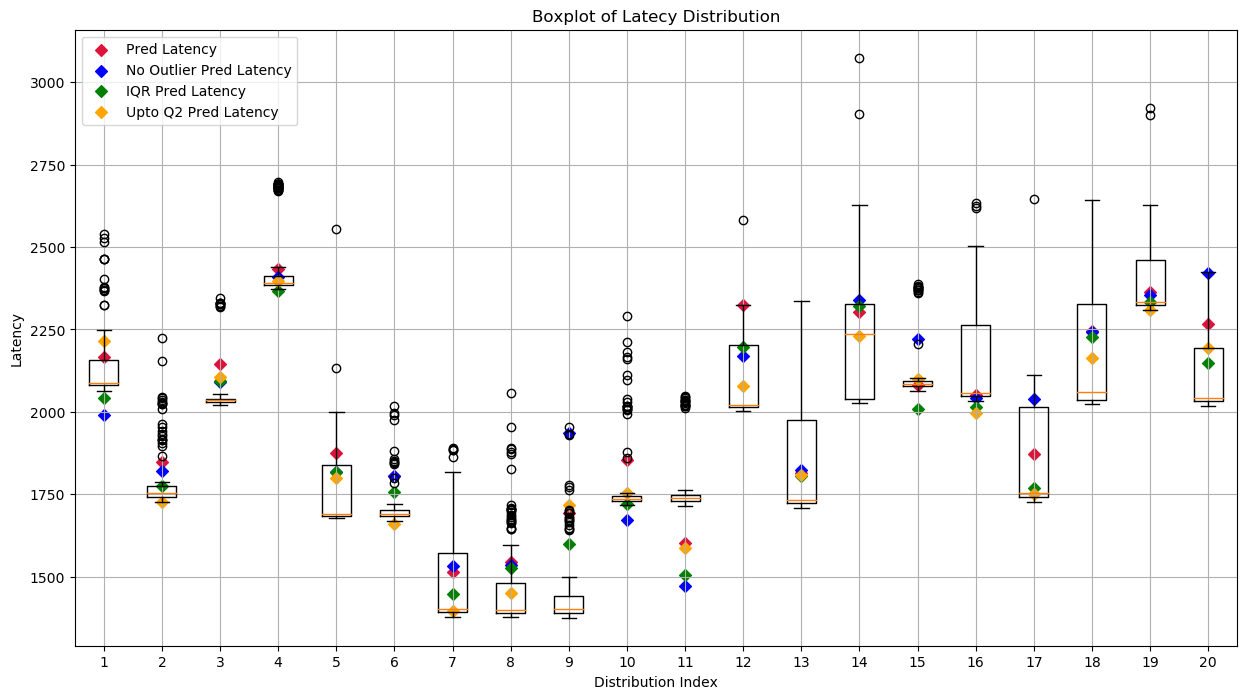

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 8))

num_of_test_data = len(list_of_latency_list)

ax.boxplot(list_of_latency_list)

# ax.plot(np.arange(1, num_of_test_data + 1), pred_latency_list, color='lightgreen')
ax.scatter(np.arange(1, num_of_test_data + 1), mean_latency_list, color='crimson', marker='D', label='Pred Latency')
ax.scatter(np.arange(1, num_of_test_data + 1), no_outlier_latency_list, color='blue', marker='D', label='No Outlier Pred Latency')
ax.scatter(np.arange(1, num_of_test_data + 1), iqr_latency_list, color='green', marker='D', label='IQR Pred Latency')
ax.scatter(np.arange(1, num_of_test_data + 1), upto_q2, color='orange', marker='D', label='Upto Q2 Pred Latency')

ax.legend()
ax.set_title('Boxplot of Latecy Distribution')
ax.set_xlabel('Distribution Index')
ax.set_ylabel('Latency')
plt.grid()
# plt.show()

#import tikzplotlib
#tikzplotlib.save("boxplot.tex")